In [2]:
import pickle
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [3]:
data = pd.read_csv("heart_dataset_2.csv")

split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
for train_index, test_index in split_data.split(data, data['target']):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

#splitting for train set data
Ftrs_train = train_set.drop(columns='target', axis=1)
Trgt_train = train_set['target']

#splitting for test set data
Ftrs_test = test_set.drop(columns='target', axis=1)
Trgt_test = test_set['target']

##### BEST PERFORMING MODELS (Top 5):

``` 
Rank       Name                       Variable Name
----------------------------------------------------
1.    Gaussian Naive Bayes             model_gnb
2.    Support Vector Machine           model_svm
3.    MLP Neural Network               model_mlp 
4.    Random Forest                    model_rfc
5.    Logistic Regression              model_logreg
```

In [4]:
model_gnb=pickle.load(open('trained_gnb.sav', 'rb'))
model_svm=pickle.load(open('trained_svm.sav', 'rb'))
model_mlp=pickle.load(open('trained_mlp.sav', 'rb'))
model_rf=pickle.load(open('trained_rfc.sav', 'rb'))
model_lr=pickle.load(open('trained_logreg.sav', 'rb'))

C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator GaussianNB from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.1 when using version 1.2.2. This might lead to breaking

### Confidence Scores for the models

In [5]:
cs_gnb=model_gnb.predict_proba(Ftrs_test)
cs_svm=model_svm.predict_proba(Ftrs_test)
cs_mlp=model_mlp.predict_proba(Ftrs_test)
cs_rf=model_rf.predict_proba(Ftrs_test)
cs_lr=model_lr.predict_proba(Ftrs_test)

### Applying Sugeno Fuzzy Integral based Ensemble Method

In [6]:
def find_max(arr):
    class_0=arr[0]
    class_1=arr[1]

    if class_0>class_1:
        return 0
    elif class_0<class_1:
        return 1
    else:
        return 1

In [7]:
from sympy.solvers import solve
from sympy import Symbol
def sugeno(solution,pred1,pred2,pred3, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) - (l+1), l )
    if len(lam) < 3:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,3):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

ModuleNotFoundError: No module named 'sympy'

In [ ]:
acc, ypred, cs_sugeno = sugeno([0.1,0.3,0.8], cs_gnb, cs_svm, cs_mlp, Trgt_test)
acc

0.9016393442622951

In [ ]:
# s=1
# l=0
# v,m=0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             try:
                
#                 acc, ypred,label= sugeno([z,jj,k],cs_gnb,cs_svm,cs_mlp,Trgt_test)
#                 print("\t",acc,"\t",z,"\t",jj,"\t",k)
#                 if acc>0.9016393442622951:
#                     print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k)
#                     l=jj
#                     m=k
#                     v=z
#             except ValueError:
#                 pass
            
                
# print("done")
# print(v,l,m)

	 0.8524590163934426 	 0.1 	 0.1 	 0.1
	 0.8688524590163934 	 0.1 	 0.1 	 0.2
	 0.8688524590163934 	 0.1 	 0.1 	 0.3
	 0.8688524590163934 	 0.1 	 0.1 	 0.4
	 0.9016393442622951 	 0.1 	 0.1 	 0.5
	 0.9016393442622951 	 0.1 	 0.1 	 0.6
	 0.9016393442622951 	 0.1 	 0.1 	 0.7
	 0.9016393442622951 	 0.1 	 0.1 	 0.9
	 0.9016393442622951 	 0.1 	 0.1 	 1.0
	 0.8688524590163934 	 0.1 	 0.2 	 0.1
	 0.8688524590163934 	 0.1 	 0.2 	 0.2
	 0.8688524590163934 	 0.1 	 0.2 	 0.3
	 0.8688524590163934 	 0.1 	 0.2 	 0.4
	 0.9016393442622951 	 0.1 	 0.2 	 0.5
	 0.9016393442622951 	 0.1 	 0.2 	 0.6
	 0.9016393442622951 	 0.1 	 0.2 	 0.8
	 0.9016393442622951 	 0.1 	 0.2 	 0.9
	 0.9016393442622951 	 0.1 	 0.2 	 1.0
	 0.8688524590163934 	 0.1 	 0.3 	 0.1
	 0.8688524590163934 	 0.1 	 0.3 	 0.2
	 0.8688524590163934 	 0.1 	 0.3 	 0.3
	 0.8852459016393442 	 0.1 	 0.3 	 0.4
	 0.9016393442622951 	 0.1 	 0.3 	 0.5
	 0.9016393442622951 	 0.1 	 0.3 	 0.7
	 0.9016393442622951 	 0.1 	 0.3 	 0.8
	 0.9016393442622951 	 0.

In [ ]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.82      0.88        28
           1       0.86      0.97      0.91        33

    accuracy                           0.90        61
   macro avg       0.91      0.90      0.90        61
weighted avg       0.91      0.90      0.90        61

Accuracy Score:  0.9016393442622951
ROC-AUC Score:  0.8955627705627704
PR-AUC Score:  0.9254776385923927


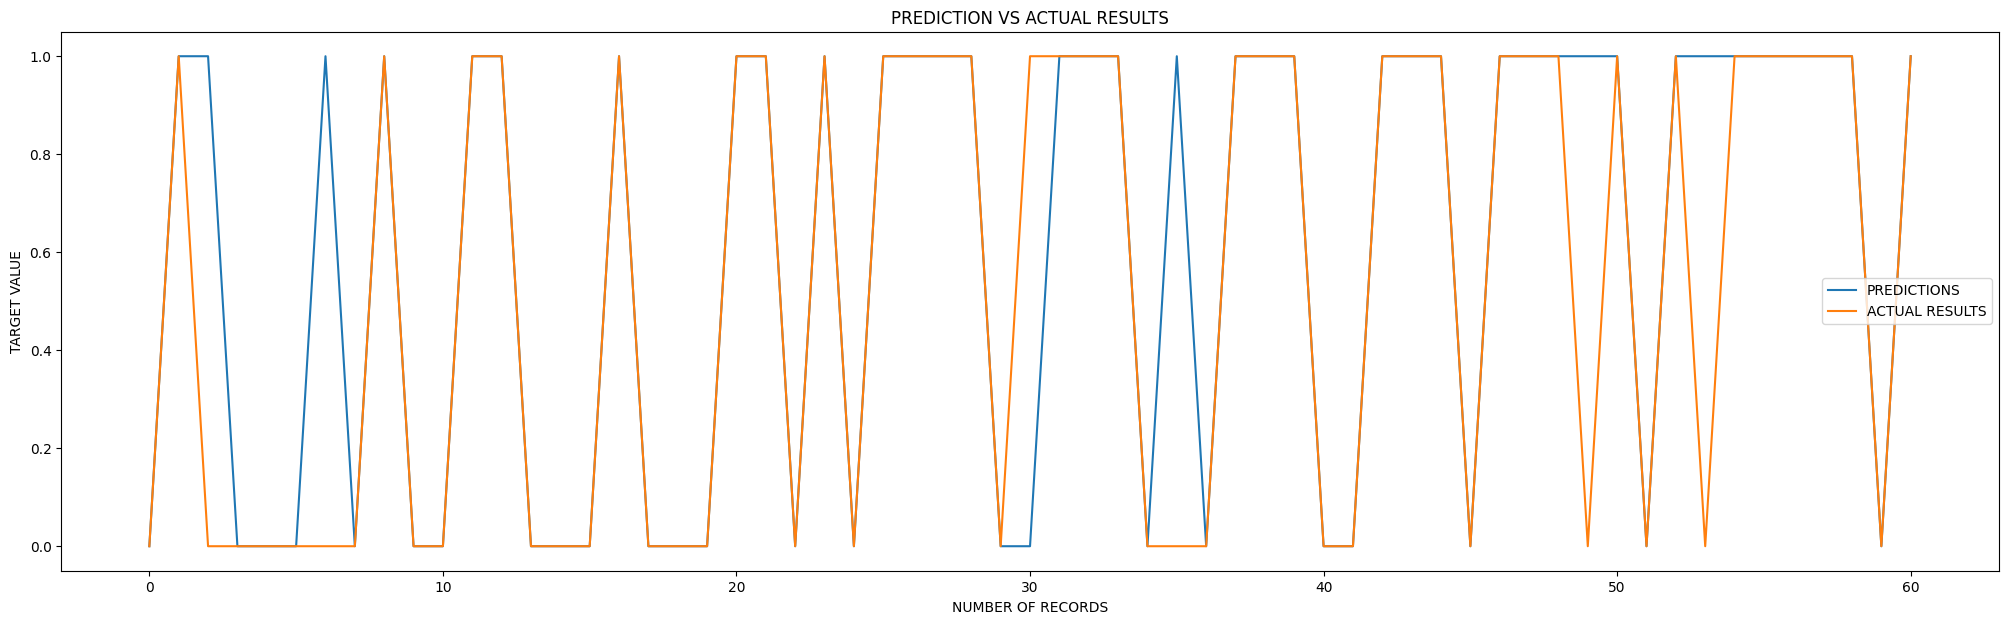

In [ ]:
fig = plt.figure(figsize=(25, 7))
plt.plot(ypred,label="PREDICTIONS")
plt.xlabel("NUMBER OF RECORDS")
plt.ylabel("TARGET VALUE")
test_result=np.array(Trgt_test)
plt.plot(test_result,label="ACTUAL RESULTS")
plt.title("PREDICTION VS ACTUAL RESULTS")
plt.legend()

# sfi(class 4)

In [ ]:
def sugeno4(solution,pred1,pred2,pred3,pred4, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2],solution[3]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) *( 1 + l* fuzzymeasures[3]) - (l+1), l )
    if len(lam) < 4:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
      elif lam[3] >= 0:
          lam = np.asarray(lam[3])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes],pred4[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,4):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                # except ValueError:
                #     sl=scoreslambda.all()
                #fuzzyprediction = max((fuzzyprediction,min((sl,ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

In [ ]:
# s=1
# l=0
# v,m,l2=0,0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             for g in range(1,11):
#                 gg=g/10
#                 try:             
#                     acc, ypred,label= sugeno([z,jj,k,gg],cs_gnb,cs_svm,cs_mlp,cs_rf,Trgt_test)
#                     print("\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                     print()
#                     if acc>=0.9016393442622951:
#                         print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         l=jj
#                         m=k
#                         v=z
#                         l2=gg
#                 except ValueError:
#                     pass
            
                
# print("done")
# print(v,l,m,l2)

	 0.8360655737704918 	 0.1 	 0.1 	 0.1 	 0.7

	 0.8360655737704918 	 0.1 	 0.1 	 0.2 	 0.6

	 0.8688524590163934 	 0.1 	 0.1 	 0.3 	 0.5

	 0.8852459016393442 	 0.1 	 0.1 	 0.4 	 0.4

	 0.9016393442622951 	 0.1 	 0.1 	 0.5 	 0.3

improoved:  	 0.9016393442622951 	 0.1 	 0.1 	 0.5 	 0.3
	 0.9016393442622951 	 0.1 	 0.1 	 0.6 	 0.2

improoved:  	 0.9016393442622951 	 0.1 	 0.1 	 0.6 	 0.2
	 0.9016393442622951 	 0.1 	 0.1 	 0.7 	 0.1

improoved:  	 0.9016393442622951 	 0.1 	 0.1 	 0.7 	 0.1
	 0.8360655737704918 	 0.1 	 0.2 	 0.1 	 0.6

	 0.8688524590163934 	 0.1 	 0.2 	 0.2 	 0.5

	 0.8852459016393442 	 0.1 	 0.2 	 0.3 	 0.4

	 0.8852459016393442 	 0.1 	 0.2 	 0.4 	 0.3

	 0.9016393442622951 	 0.1 	 0.2 	 0.5 	 0.2

improoved:  	 0.9016393442622951 	 0.1 	 0.2 	 0.5 	 0.2
	 0.9016393442622951 	 0.1 	 0.2 	 0.6 	 0.1

improoved:  	 0.9016393442622951 	 0.1 	 0.2 	 0.6 	 0.1
	 0.8688524590163934 	 0.1 	 0.3 	 0.1 	 0.5

	 0.8852459016393442 	 0.1 	 0.3 	 0.2 	 0.4

	 0.8852459016393442 	 0.

In [ ]:
acc, ypred,label= sugeno4([0.3,0.1,0.5,0.1],cs_gnb,cs_svm,cs_mlp,cs_rf,Trgt_test)
acc

0.9016393442622951

In [ ]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        28
           1       0.89      0.94      0.91        33

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61

Accuracy Score:  0.9016393442622951
ROC-AUC Score:  0.8982683982683983
PR-AUC Score:  0.9289475551770634


# sfi(class 5)

In [ ]:
def sugeno5(solution,pred1,pred2,pred3,pred4,pred5, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2],solution[3],solution[4]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) *( 1 + l* fuzzymeasures[3]) *( 1 + l* fuzzymeasures[4]) - (l+1), l )
    if len(lam) < 5:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
      elif lam[3] >= 0:
          lam = np.asarray(lam[3])
      elif lam[4] >= 0:
          lam = np.asarray(lam[4])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes],pred4[sample][classes],pred5[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,5):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                # except ValueError:
                #     sl=scoreslambda.all()
                #fuzzyprediction = max((fuzzyprediction,min((sl,ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

In [ ]:
# for p in range(1,11):
#     pp=p/10;
#     try:
#         acc, ypred,label= sugeno([0.3,0.1,0.5,0.1,pp],cs_gnb,cs_svm,cs_mlp,cs_rf,cs_lr,Trgt_test)
#         print(acc,"\t",pp)
#         print()
#         if acc>=0.907608695652174:
#             print("improoved/tie: ","\t",acc,"\t",pp)
#     except ValueError:
#         pass

# print("done")

done


In [ ]:
# s=1
# l=0
# v,m,l2,l3=0,0,0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             for g in range(1,11):
#                 gg=g/10
#                 for p in range(1,11):
#                     pp=p/10
#                     try:             
#                         acc, ypred,label= sugeno([z,jj,k,gg,pp],cs_gnb,cs_svm,cs_mlp,cs_rf,cs_lr,Trgt_test)
#                         print("\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         print()
#                         # if acc>0.9130434782608695:
#                         #     print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         #     l=jj
#                         #     m=k
#                         #     v=z
#                         #     l2=gg
#                         if acc>=0.907608695652174:
#                             print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                             l=jj
#                             m=k
#                             v=z
#                             l2=gg
#                     except ValueError:
#                         pass
            
                
# print("done")
# print(v,l,m,l2,l3)

	 0.8688524590163934 	 0.1 	 0.1 	 0.4 	 0.9

	 0.8688524590163934 	 0.1 	 0.1 	 0.4 	 1.0

	 0.8852459016393442 	 0.1 	 0.1 	 0.5 	 0.7

	 0.8852459016393442 	 0.1 	 0.1 	 0.5 	 0.8

	 0.8852459016393442 	 0.1 	 0.1 	 0.5 	 0.8

	 0.8852459016393442 	 0.1 	 0.1 	 0.5 	 0.9

	 0.8852459016393442 	 0.1 	 0.1 	 0.5 	 0.9

	 0.8852459016393442 	 0.1 	 0.1 	 0.5 	 0.9

	 0.8688524590163934 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8688524590163934 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8688524590163934 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8852459016393442 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8852459016393442 	 0.1 	 0.1 	

KeyboardInterrupt: 

In [ ]:
# #0.1 	 0.9 	 0.6 	 0.8

# for p in range(1,11):
#     pp=p/10;
#     try:
#         acc, ypred,label= sugeno([ 0.1,0.9,0.6,0.8,pp],cs_gnb,cs_svm,cs_mlp,cs_rf,cs_lr,Trgt_test)
#         print(acc,"\t",pp)
#         print()
#         if acc>=0.873170731707317:
#             print("improoved/tie: ","\t",acc,"\t",pp)
#     except ValueError:
#         pass

# print("done")

0.8852459016393442 	 0.1

improoved/tie:  	 0.8852459016393442 	 0.1
done


In [ ]:
acc, ypred,label= sugeno5([ 0.1,0.9,0.6,0.8,0.1],cs_gnb,cs_svm,cs_mlp,cs_rf,cs_lr,Trgt_test)
acc

0.8852459016393442

In [ ]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy Score:  0.8852459016393442
ROC-AUC Score:  0.8804112554112554
PR-AUC Score:  0.9166459678754761


gnb,
svm,
mlp,
rf

Voting (Class3)

In [ ]:
from sklearn.ensemble import VotingClassifier
clf1 = GaussianNB()
clf2 = SVC()
clf3 = MLPClassifier()
#eclf1 = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('GNB', clf3), ('RF', clf4)], voting='soft')
#eclf1.fit(Ftrs_train, Trgt_train)
#predic = eclf1.predict(Ftrs_test)
eclf = VotingClassifier(estimators=[('GNB', clf1), ('SVC', clf2), ('MLP', clf3)], voting='hard')
eclf.fit(Ftrs_train, Trgt_train)
ypredv = eclf.predict(Ftrs_test)
#print(classification_report(Ftrs_test))
print(classification_report(Trgt_test, ypredv))

roc_auc = roc_auc_score(Trgt_test, ypredv)
print("ROC-AUC Score:", roc_auc)

pr_auc = average_precision_score(Trgt_test, ypredv)
print("PR-AUC Score:", pr_auc)


              precision    recall  f1-score   support

           0       0.91      0.75      0.82        28
           1       0.82      0.94      0.87        33

    accuracy                           0.85        61
   macro avg       0.86      0.84      0.85        61
weighted avg       0.86      0.85      0.85        61

ROC-AUC Score: 0.8446969696969697
PR-AUC Score: 0.7991345726462206


Voting(Class 4)

In [ ]:
from sklearn.ensemble import VotingClassifier
clf1 = GaussianNB()
clf2 = SVC()
clf3 = MLPClassifier()
clf4 = RandomForestClassifier()
#eclf1 = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('GNB', clf3), ('RF', clf4)], voting='soft')
#eclf1.fit(Ftrs_train, Trgt_train)
#predic = eclf1.predict(Ftrs_test)
eclf = VotingClassifier(estimators=[('GNB', clf1), ('SVC', clf2), ('MLP', clf3), ('RF', clf4)], voting='hard')
eclf.fit(Ftrs_train, Trgt_train)
ypredv = eclf.predict(Ftrs_test)
#print(classification_report(Ftrs_test))
print(classification_report(Trgt_test, ypredv))

roc_auc = roc_auc_score(Trgt_test, ypredv)
print("ROC-AUC Score:", roc_auc)

pr_auc = average_precision_score(Trgt_test, ypredv)
print("PR-AUC Score:", pr_auc)


              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

ROC-AUC Score: 0.8804112554112554
PR-AUC Score: 0.8417094441684606


Bagging

In [ ]:
from sklearn.ensemble import BaggingRegressor
  
bag_regressor = BaggingRegressor(random_state=1)
bag_regressor.fit(Ftrs_train,Trgt_train)
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)
ypredb = bag_regressor.predict(Ftrs_test)
print('accuracy : %f' %bag_regressor.score(Ftrs_train, Trgt_train))





roc_auc = roc_auc_score(Trgt_test, ypredb)
print("ROC-AUC Score:", roc_auc)

pr_auc = average_precision_score(Trgt_test, ypredb)
print("PR-AUC Score:", pr_auc)

accuracy : 0.908333
ROC-AUC Score: 0.8690476190476191
PR-AUC Score: 0.8487439749734832


Stacking(Class 3) final estimator= GNB

In [ ]:
estimators = [
    ('gnb', GaussianNB()),
    ('svm',SVC()),
    ('mlp', MLPClassifier())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GaussianNB(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



Classification Report
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.84      0.94      0.89        33

    accuracy                           0.87        61
   macro avg       0.88      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61

Accuracy Score:  0.8688524590163934
ROC-AUC Score:  0.8625541125541125
PR-AUC Score:  0.9050093312388394


C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


final estimator= SVC

In [ ]:
estimators = [
    ('gnb', GaussianNB()),
    ('svm',SVC()),
    ('mlp', MLPClassifier())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=SVC(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy Score:  0.8852459016393442
ROC-AUC Score:  0.8804112554112554
PR-AUC Score:  0.9166459678754761


final estimator= MLP

In [ ]:
estimators = [
    ('gnb', GaussianNB()),
    ('svm',SVC()),
    ('mlp', MLPClassifier())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=MLPClassifier(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy Score:  0.8852459016393442
ROC-AUC Score:  0.8804112554112554
PR-AUC Score:  0.9166459678754761


C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Stacking(Class4) final estimator= GNB

In [ ]:
estimators = [
    ('gnb', GaussianNB()),
    ('svm',SVC()),
    ('mlp', MLPClassifier()),
    ('rf', RandomForestClassifier())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GaussianNB(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds22)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy Score:  0.8852459016393442
ROC-AUC Score:  0.8804112554112554
PR-AUC Score:  0.9166459678754761


final estimator = SVM

In [ ]:
estimators = [
    ('gnb', GaussianNB()),
    ('svm',SVC()),
    ('mlp', MLPClassifier()),
    ('rf', RandomForestClassifier())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=SVC(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy Score:  0.8852459016393442
ROC-AUC Score:  0.8804112554112554
PR-AUC Score:  0.9166459678754761


final estimator= MLP

In [ ]:
estimators = [
    ('gnb', GaussianNB()),
    ('svm',SVC()),
    ('mlp', MLPClassifier()),
    ('rf', RandomForestClassifier())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=MLPClassifier(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        28
           1       0.86      0.94      0.90        33

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61

Accuracy Score:  0.8852459016393442
ROC-AUC Score:  0.8804112554112554
PR-AUC Score:  0.9166459678754761


C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


final estimator = RF

In [ ]:
estimators = [
    ('gnb', GaussianNB()),
    ('svm',SVC()),
    ('mlp', MLPClassifier()),
    ('rf', RandomForestClassifier())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=RandomForestClassifier(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        28
           1       0.83      0.91      0.87        33

    accuracy                           0.85        61
   macro avg       0.86      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

Accuracy Score:  0.8524590163934426
ROC-AUC Score:  0.8474025974025974
PR-AUC Score:  0.8958022851465475


Weighted Avg(Class 4)

In [ ]:
clf1 = GaussianNB()
clf2 = SVC()
clf3 = MLPClassifier()
clf4 = RandomForestClassifier()

clf1.fit(Ftrs_train, Trgt_train)
clf2.fit(Ftrs_train, Trgt_train)
clf3.fit(Ftrs_train, Trgt_train)
clf4.fit(Ftrs_train, Trgt_train)

predictions1 = clf1.predict(Ftrs_test)
predictions2 = clf2.predict(Ftrs_test)
predictions3 = clf3.predict(Ftrs_test)
predictions4 = clf4.predict(Ftrs_test)

weights = [0.3, 0.2, 0.3, 0.2]
weighted_avg_pred_prob = (weights[0] * predictions1 + 
                          weights[1] * predictions2 + 
                          weights[2] * predictions3 +
                          weights[3] * predictions4) / sum(weights)


weighted_avg_predictions = (weighted_avg_pred_prob > 0.5).astype(int)


accuracy = accuracy_score(Trgt_test, weighted_avg_predictions)




print("Classification Report")
print(classification_report(Trgt_test,weighted_avg_predictions))

print("Accuracy Score: ", accuracy)


roc_auc = roc_auc_score(Trgt_test, weighted_avg_predictions)
print("Weighted Average Classifier ROC-AUC Score:", roc_auc)
pr_auc = average_precision_score(Trgt_test, weighted_avg_predictions)
print("Weighted Average Classifier PR-AUC Score:", pr_auc)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.84      0.82      0.83        33

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61

Accuracy Score:  0.819672131147541
Weighted Average Classifier ROC-AUC Score: 0.8198051948051949
Weighted Average Classifier PR-AUC Score: 0.7887015648286141


Weighted Avg(Class 3)

In [8]:
clf1 = MLPClassifier()
clf2 = SVC()
clf3 = GaussianNB()


clf1.fit(Ftrs_train, Trgt_train)
clf2.fit(Ftrs_train, Trgt_train)
clf3.fit(Ftrs_train, Trgt_train)


predictions1 = clf1.predict(Ftrs_test)
predictions2 = clf2.predict(Ftrs_test)
predictions3 = clf3.predict(Ftrs_test)

weights = [0.3, 0.2, 0.3, 0.2]
weighted_avg_pred_prob = (weights[0] * predictions1 + 
                          weights[1] * predictions2 + 
                          weights[2] * predictions3) / sum(weights)


weighted_avg_predictions = (weighted_avg_pred_prob > 0.5).astype(int)


accuracy = accuracy_score(Trgt_test, weighted_avg_predictions)




print("Classification Report")
print(classification_report(Trgt_test,weighted_avg_predictions))

print("Accuracy Score: ", accuracy)


roc_auc = roc_auc_score(Trgt_test, weighted_avg_predictions)
print("Weighted Average Classifier ROC-AUC Score:", roc_auc)
pr_auc = average_precision_score(Trgt_test, weighted_avg_predictions)
print("Weighted Average Classifier PR-AUC Score:", pr_auc)


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61

Accuracy Score:  0.8360655737704918
Weighted Average Classifier ROC-AUC Score: 0.83495670995671
Weighted Average Classifier PR-AUC Score: 0.8018937512231105
